In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

## Halo Catalog

In [2]:
# load a test halo catalog

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')

# add estimate of minor axis
from rotations.vector_utilities import normalized_vectors
B = np.vstack((halocat.halo_table['halo_axisA_x'],
               halocat.halo_table['halo_axisA_y'],
               halocat.halo_table['halo_axisA_z'])).T
A = np.vstack((halocat.halo_table['halo_jx'],
               halocat.halo_table['halo_jy'],
               halocat.halo_table['halo_jz'])).T
B = normalized_vectors(B)
A = normalized_vectors(A)

D = np.cross(A, B)
C = np.cross(B, D)

halocat.halo_table['halo_axisC_x'] = C[:,0]
halocat.halo_table['halo_axisC_y'] = C[:,1]
halocat.halo_table['halo_axisC_z'] = C[:,2]

# get host halo properties
from halotools.utils import crossmatch
halo_hostid = halocat.halo_table['halo_hostid']
halo_id = halocat.halo_table['halo_id']
inds1, inds2 = crossmatch(halo_hostid, halo_id)
halocat.halo_table['halo_rvir'][inds1] = halocat.halo_table['halo_rvir'][inds2]

## (sub-)halo correlations

In [3]:
from halotools.mock_observables import tpcf_jackknife
from intrinsic_alignments.utils.jackknife_observables import jackknife_ed_3d, jackknife_ee_3d

rbins = np.logspace(-1,1.2,13)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

# empirical halo and sub-halo correlations

halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

# define host and sub-halo samples
hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1

# define host halo IDs
host_ids = halocat.halo_table['halo_hostid']

# define halo sub-samples
halo_mask = (halocat.halo_table['halo_mpeak']>10**12.0)

In [4]:
# calculate ED correaltion functions
halo_omega, halo_omega_cov = jackknife_ed_3d(halo_coords[halo_mask], 
                                             halo_orientations[halo_mask],
                                             halo_coords[halo_mask],
                                             rbins, Nsub = [3,3,3],
                                             period=halocat.Lbox, num_threads=4,
                                             verbose=True)
halo_omega_err = np.sqrt(np.diag(halo_omega_cov))

estimated time to complete jackknife calculation (s): 26.008848667144775


In [5]:
# calculate EE correaltion functions
halo_eta, halo_eta_cov = jackknife_ee_3d(halo_coords[halo_mask], 
                                         halo_orientations[halo_mask],
                                         halo_coords[halo_mask],
                                         halo_orientations[halo_mask],
                                         rbins, Nsub = [4,4,4],
                                         period=halocat.Lbox, num_threads=4,
                                         verbose=True)
halo_eta_err = np.sqrt(np.diag(halo_eta_cov))

estimated time to complete jackknife calculation (s): 53.64155578613281


In [6]:
N = 10**5
randoms = np.random.random((N,3))*halocat.Lbox
halo_xi, halo_xi_cov =  tpcf_jackknife(halo_coords[halo_mask], randoms,
                                       rbins, Nsub=[4, 4, 4], period=halocat.Lbox, num_threads=4)
halo_xi_err = np.sqrt(np.diag(halo_xi_cov))

## Halo Model

In [7]:
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment, RadialSatelliteAlignmentStrength
from intrinsic_alignments.ia_models.occupation_models import SubHaloPositions, TriaxialNFW

In [8]:
satellite_alignment_strength = RadialSatelliteAlignmentStrength(satellite_alignment_a= 0.00650463)
satellite_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=0.83, Lbox=halocat.Lbox)
central_alignment_model = CentralAlignment(central_alignment_strength=0.999)

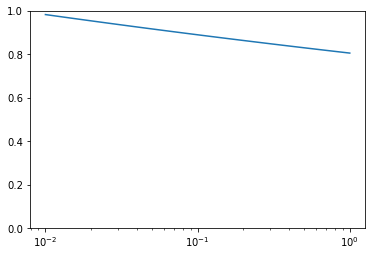

In [9]:
r = np.logspace(-2,0,100)
plt.plot(r, satellite_alignment_strength.alignment_strength_radial_dependence(r))
plt.xscale('log')
plt.ylim([0,1])
plt.show()

## Anisotropy Effect

In [10]:
# define subhalo positions
satellite_position_model = TriaxialNFW(anisotropy_bias=4.0, Lbox=halocat.Lbox)
#satellite_position_model = SubHaloPositions()

table = Table(np.copy(halocat.halo_table))
table = satellite_position_model.assign_gal_type(table=table)
table = satellite_position_model.assign_positions(table=table)

table = central_alignment_model.assign_central_orientation(table=table)
table = satellite_alignment_strength.assign_satellite_alignment_strength(table=table, Lbox=halocat.Lbox)
table = satellite_alignment_model.assign_satellite_orientation(table=table)

/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/occupation_models.py:515: UserWarning: There are 460 sub-haloes with no host halo.
  warn(msg)
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:189: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1051: VisibleDeprecationWarning: The signature of <bound method DimrothWatson._rvs of <watson_dist.watson_dist.watson_distribution.DimrothWatson object at 0x2b264c65a040>> does not contain a "size" keyword.  Such signatures are deprecated.
  warnings.warn(
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:583: UserWarning: 1033565 galaxies have a radial distance equal to zero (or infinity) from their host. These galaxies will be re-assigned random alig

In [11]:
# get host halo properties
halo_hostid = halocat.halo_table['halo_hostid']
halo_id = halocat.halo_table['halo_id']
inds1, inds2 = crossmatch(halo_hostid, halo_id)
halo_x = halocat.halo_table['halo_x']
halo_y = halocat.halo_table['halo_y']
halo_z = halocat.halo_table['halo_z']

from intrinsic_alignments.ia_models.occupation_models import radial_distance
rr = radial_distance(halo_x[inds1], halo_y[inds1], halo_z[inds1],
                     halo_x[inds2], halo_y[inds2], halo_z[inds2],
                     Lbox=halocat.Lbox)[1]

In [12]:
mask = (halo_hostid==3060299107)
halocat.halo_table['halo_x'][mask]

35.72499
35.59784
35.88582
34.83579
35.67586
35.51022
35.2747
35.25866
35.96299
35.03138
35.37808


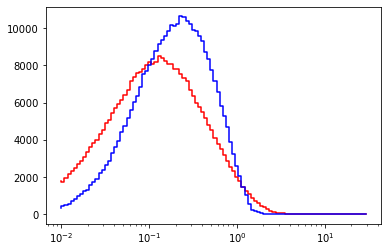

In [13]:
rbins = np.logspace(-2,1.5,100)
counts1 = np.histogram(table['r'], bins=rbins)[0]
counts2 = np.histogram(rr, bins=rbins)[0]

plt.step(rbins[:-1], counts1, color='red')
plt.step(rbins[:-1], counts2, color='blue')
plt.xscale('log')

In [14]:
mask = (table['halo_mpeak']>10**12.0)

coords = np.vstack((table['x'],table['y'],table['z'])).T
coords = coords[mask]

orientations = np.vstack((table['galaxy_axisA_x'],
                          table['galaxy_axisA_y'],
                          table['galaxy_axisA_z'])).T
orientations = orientations[mask]

In [16]:
from halotools.mock_observables import tpcf
from halotools_ia.correlation_functions import ed_3d, ee_3d

rbins = np.logspace(-1,1.2,13)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

xi = tpcf(coords, rbins=rbins, period=halocat.Lbox, num_threads=4)

omega = ed_3d(coords, orientations,
              coords,
              rbins, period=halocat.Lbox, num_threads=4)

eta = ee_3d(coords, orientations,
              coords, orientations,
              rbins, period=halocat.Lbox, num_threads=4)

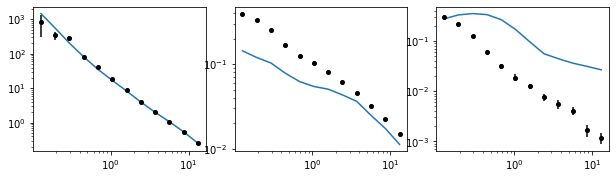

In [17]:
ps = np.linspace(1,0,10)
colors = np.linspace(1.0,0.5,len(ps))
colors = plt.cm.cool(colors)

fig = plt.figure(figsize=(8.0,4.0))

# TPCF
rect = (0.1,0.4,0.3,0.5) # [left, bottom, width, height]

ax = plt.axes(rect)
l0 = ax.errorbar(rbin_centers, halo_xi, yerr=halo_xi_err,
                 fmt='o', color='black', ms=4)
ax.plot(rbin_centers, xi, '-')
ax.set_yscale('log')
ax.set_xscale('log')

# ED
rect = (0.45,0.4,0.3,0.5) # [left, bottom, width, height]

ax = plt.axes(rect)
l0 = ax.errorbar(rbin_centers, halo_omega, yerr=halo_omega_err,
                 fmt='o', color='black', ms=4)
ax.plot(rbin_centers, omega, '-')
ax.set_yscale('log')
ax.set_xscale('log')

# EE
rect = (0.8,0.4,0.3,0.5) # [left, bottom, width, height]

ax = plt.axes(rect)
l0 = ax.errorbar(rbin_centers, halo_eta, yerr=halo_eta_err,
                 fmt='o', color='black', ms=4)
ax.plot(rbin_centers, eta, '-')
ax.set_yscale('log')
ax.set_xscale('log')

# subhalo anisotropy

In [18]:
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment
from intrinsic_alignments.ia_models.occupation_models import SubHaloPositions, IsotropicSubhaloPositions, SemiIsotropicSubhaloPositions

In [19]:
# define subhalo positions
satellite_position_model_1 = SubHaloPositions()

table_1 = Table(np.copy(halocat.halo_table))
table_1 = satellite_position_model_1.assign_gal_type(table=table_1)
table_1 = satellite_position_model_1.assign_positions(table=table_1)

In [20]:
# define subhalo and host halo alignments
satellite_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=0.85, Lbox=halocat.Lbox)
central_alignment_model = CentralAlignment(central_alignment_strength=0.99)

table_1 = central_alignment_model.assign_central_orientation(table=table_1)
table_1 = satellite_alignment_model.assign_satellite_orientation(table=table_1)

/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:189: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1051: VisibleDeprecationWarning: The signature of <bound method DimrothWatson._rvs of <watson_dist.watson_dist.watson_distribution.DimrothWatson object at 0x2b264d4ceca0>> does not contain a "size" keyword.  Such signatures are deprecated.
  warnings.warn(
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:583: UserWarning: 1033565 galaxies have a radial distance equal to zero (or infinity) from their host. These galaxies will be re-assigned random alignment vectors.
  warn(msg)
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:592: UserWarning: `satellite_alignment_streng

In [21]:
# examine galaxy-galaxy correlation function
from halotools.mock_observables import tpcf

rbins = np.logspace(-1,1.2,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

mask_0 = (halocat.halo_table['halo_mpeak']>10**12.5)
mask_1 = (table_1['halo_mpeak']>10**12.5)

coords_0 = np.vstack((halocat.halo_table['halo_x'],
                      halocat.halo_table['halo_y'],
                      halocat.halo_table['halo_z'])).T
result_0 = tpcf(coords_0[mask_0], rbins=rbins, period=halocat.Lbox)

coords_1 = np.vstack((table_1['x'],table_1['y'],table_1['z'])).T
result_1 = tpcf(coords_1[mask_1], rbins=rbins, period=halocat.Lbox, num_threads=4)

In [22]:
from halotools_ia.correlation_functions import ed_3d, ee_3d

orientations_0 = np.vstack((halocat.halo_table['halo_axisA_x'],
                            halocat.halo_table['halo_axisA_y'],
                            halocat.halo_table['halo_axisA_z'])).T
mask = (np.prod(orientations_0*orientations_0,axis=-1)==0)
orientations_0[mask,:] = np.random.random(3)

orientations_1 = np.vstack((table_1['galaxy_axisA_x'],
                            table_1['galaxy_axisA_y'],
                            table_1['galaxy_axisA_z'])).T
mask = (np.prod(orientations_1*orientations_1,axis=-1)==0)

# calculate ED correaltion functions
omega_0 = ed_3d(coords_0[mask_0], orientations_0[mask_0],
                coords_0[mask_0],
                rbins, period=halocat.Lbox, num_threads=4)

omega_1 = ed_3d(coords_1[mask_1], orientations_1[mask_1],
                coords_1[mask_1],
                rbins, period=halocat.Lbox, num_threads=4)


# calculate EE correaltion functions
eta_0 = ee_3d(coords_0[mask_0], orientations_0[mask_0],
              coords_0[mask_0], orientations_0[mask_0],
              rbins, period=halocat.Lbox, num_threads=4)

eta_1 = ee_3d(coords_1[mask_1], orientations_1[mask_1],
              coords_1[mask_1], orientations_1[mask_1],
              rbins, period=halocat.Lbox, num_threads=4)

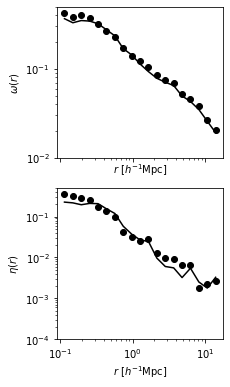

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(3.3,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = ax1
l0, = ax.plot(rbin_centers, omega_0, 'o', color='black')
l1, = ax.plot(rbin_centers, omega_1, '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.01,0.5])

ax = ax2
l0, = ax.plot(rbin_centers, eta_0, 'o', color='black')
l1, = ax.plot(rbin_centers, eta_1, '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

plt.show()

In [24]:
from intrinsic_alignments.ia_models.occupation_models import TriaxialNFW

# add estimate of minor axis
from rotations.vector_utilities import normalized_vectors
B = np.vstack((halocat.halo_table['halo_axisA_x'],
               halocat.halo_table['halo_axisA_y'],
               halocat.halo_table['halo_axisA_z'])).T
A = np.vstack((halocat.halo_table['halo_jx'],
               halocat.halo_table['halo_jy'],
               halocat.halo_table['halo_jz'])).T
B = normalized_vectors(B)
A = normalized_vectors(A)

D = np.cross(A, B)
C = np.cross(B, D)

halocat.halo_table['halo_axisC_x'] = C[:,0]
halocat.halo_table['halo_axisC_y'] = C[:,1]
halocat.halo_table['halo_axisC_z'] = C[:,2]

# define subhalo positions
satellite_position_model_2 = TriaxialNFW(anisotropy_bias=0.0, Lbox=halocat.Lbox)
# define subhalo positions
satellite_position_model_3 = TriaxialNFW(anisotropy_bias=5.0, Lbox=halocat.Lbox)

table_2 = Table(np.copy(halocat.halo_table))
table_2 = satellite_position_model_2.assign_gal_type(table=table_2)
table_2 = satellite_position_model_2.assign_positions(table=table_2)

table_3 = Table(np.copy(halocat.halo_table))
table_3 = satellite_position_model_3.assign_gal_type(table=table_3)
table_3 = satellite_position_model_3.assign_positions(table=table_3)

# define subhalo and host halo alignments
satellite_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=0.85, Lbox=halocat.Lbox)
central_alignment_model = CentralAlignment(central_alignment_strength=0.99)

table_2 = central_alignment_model.assign_central_orientation(table=table_2)
table_2 = satellite_alignment_model.assign_satellite_orientation(table=table_2)

table_3 = central_alignment_model.assign_central_orientation(table=table_3)
table_3 = satellite_alignment_model.assign_satellite_orientation(table=table_3)

/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/occupation_models.py:515: UserWarning: There are 460 sub-haloes with no host halo.
  warn(msg)
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/occupation_models.py:515: UserWarning: There are 460 sub-haloes with no host halo.
  warn(msg)
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_models/ia_model_components.py:189: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1051: VisibleDeprecationWarning: The signature of <bound method DimrothWatson._rvs of <watson_dist.watson_dist.watson_distribution.DimrothWatson object at 0x2b264da42910>> does not contain a "size" keyword.  Such signatures are deprecated.
  warnings.warn(
/home/nvanalfen/github_repos/intrinsic_alignments/intrinsic_alignments/ia_mod

In [25]:
mask_2 = (table_2['halo_mpeak']>10**12.5)

coords_2 = np.vstack((table_2['x'],table_2['y'],table_2['z'])).T
result_2 = tpcf(coords_2[mask_2], rbins=rbins, period=halocat.Lbox, num_threads=4)

mask_3 = (table_3['halo_mpeak']>10**12.5)

coords_3 = np.vstack((table_3['x'],table_3['y'],table_3['z'])).T
result_3 = tpcf(coords_3[mask_3], rbins=rbins, period=halocat.Lbox, num_threads=4)

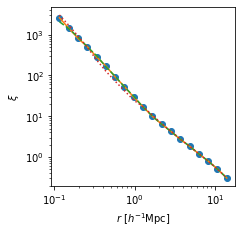

In [26]:
fig = plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(rbin_centers, result_0, 'o')
l1, = plt.plot(rbin_centers, result_1, '-')
l2, = plt.plot(rbin_centers, result_2, '--')
l2, = plt.plot(rbin_centers, result_3, ':')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$\xi$')
plt.show()

In [27]:
orientations_2 = np.vstack((table_2['galaxy_axisA_x'],
                            table_2['galaxy_axisA_y'],
                            table_2['galaxy_axisA_z'])).T

omega_2 = ed_3d(coords_2[mask_2], orientations_2[mask_2],
              coords_2[mask_2],
              rbins, period=halocat.Lbox, num_threads=4)

eta_2 = ee_3d(coords_2[mask_2], orientations_2[mask_2],
              coords_2[mask_2], orientations_2[mask_2],
              rbins, period=halocat.Lbox, num_threads=4)

In [28]:
orientations_3 = np.vstack((table_3['galaxy_axisA_x'],
                            table_3['galaxy_axisA_y'],
                            table_3['galaxy_axisA_z'])).T

omega_3 = ed_3d(coords_3[mask_3], orientations_3[mask_3],
              coords_3[mask_3],
              rbins, period=halocat.Lbox, num_threads=4)

eta_3 = ee_3d(coords_3[mask_3], orientations_3[mask_3],
              coords_3[mask_3], orientations_3[mask_3],
              rbins, period=halocat.Lbox, num_threads=4)